In [30]:
# Instalar las librerías correspondientes para correr el proyecto
# pip install numpy scipy matplotlib seaborn scikit-learn mesa==3.0 -q

# Sistema de Recolección de Alimentos pero evita de regreso a la base la comida

## Objetivo del Sistema: 
Desarrollar un sistema donde agentes llamados 'exploradores' buscan comida y la llevan de vuelta a su base. Los exploradores se desplazan buscando celdas con alimentos y regresan a la base una vez que encuentran un recurso.

## Características del Sistema:
- Energia del Explorador: Cada explorador comienza con una energía máxima de X unidades, y cada movimiento consume 1 unidad de energía. Al llegar a la base, el explorador recarga completamente su energía.

- Ubicación de la Base: La base siempre se encuentra en el centro del área de búsqueda.

- Parámetros del Sistema:   
Un área de NxN celdas.  
Un número específico de exploradores.  
Una base fija en una celda determinada.  
Un número de recursos.  
Un máximo de energía que los exploradores pueden tener.  

## Distribución de Agentes y Recursos  
Tanto los agentes como los recursos se distribuyen aleatoriamente al inicio de la simulación.  

## Comportamiento por Paso:  
- Si la celda contiene recursos, el agente los recoge y regresa a la base.  
- Si la celda no contiene recursos, el agente elige una dirección aleatoria para moverse (una de las 4 celdas vecinas) a una celda sin otro agente. Si no puede moverse allí, permanecerá en la misma celda.  

## Instrucciones para la Simulación y el Análisis
1. Simulacion inicial:  
- Ejecuta una simulación para una matriz de 11x11 con 5 exploradores y 20 recursos.  
- Todos los agentes deben empezar con 100 unidades de energía.  
- Muestra gráficamente el comportamiento del modelo.  
- Recupera, y muestra, los siguiente datos de tu simulación:  
número de pasos necesarios para recolectar todos los recursos  
cuántos recursos recuperó cada agente  
cuántas recargar totales tuvo que hacer cada agente  

## Imports

----------------------------------------------

In [31]:
from mesa import Agent, Model

from mesa.space import SingleGrid

from mesa.time import RandomActivation

from mesa.datacollection import DataCollector

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
plt.rcParams["animation.html"] = "jshtml"
matplotlib.rcParams['animation.embed_limit'] = 2**128

import numpy as np
import pandas as pd

import time
import datetime

In [32]:
class FoodExplorerAgent(Agent):
    def __init__(self, model, _energy, agent_id):
        super().__init__(model)
        self.visited_cells = 1
        self.total_recharges = 0 
        self.resource_obtained = 0
        self.max_energy = _energy
        self.energy = _energy
        #self.found_food = False
        self.returning_base = False
        self.agent_id = agent_id

    def move_to_base(self):
        possible_positions = self.model.grid.get_neighborhood(self.pos, include_center = False, moore = False)
        base_x, base_y = self.model.base_coord
        min_dist = float('inf') 
        best_pos = None

        for pos in possible_positions:
            if self.model.grid.is_cell_empty(pos) and self.model.cells[pos[0]][pos[1]] != 1:
                dist = abs(pos[0] - base_x) + abs(pos[1] - base_y)
                if dist < min_dist:
                    min_dist = dist
                    best_pos = pos

        #if best_pos and self.energy == (abs(self.pos[0] - base_x) + abs(self.pos[1] - base_y)):
        self.model.grid.move_agent(self, best_pos)
        self.visited_cells += 1
        self.energy -= 1
        self.returning_base = True

    def move(self):
        possible_positions = self.model.grid.get_neighborhood(self.pos, moore=False, include_center=False)
        #print("Poss: ", possible_positions)
        base_x, base_y = self.model.base_coord
        dist = abs(self.pos[0] - base_x) + abs(self.pos[1] - base_y)

        options = np.random.permutation(len(possible_positions))

        if self.energy == dist:
            self.move_to_base()
        else: 
            for i in options:
                new_pos = possible_positions[i]
                if self.model.grid.is_cell_empty(new_pos) and new_pos != self.model.base_coord:
                    self.model.grid.move_agent(self, new_pos)
                    self.visited_cells += 1
                    self.energy -= 1
                    #print("Energy", self.energy)
                    #print("Pos: ", self.pos)
                    break

    def step(self):
        (x,y) = self.pos
        # siempre que esté en base y no tenga full energía, recarga
        if self.pos == self.model.base_coord and self.energy < self.max_energy:
            self.energy = self.max_energy
            self.total_recharges += 1
            self.returning_base = False

        if self.model.cells[x][y] == 1:  # encontró comida
            self.resource_obtained += 1
            self.model.cells[x][y] = 0
            self.returning_base = True
            #self.found_food = True
        elif self.returning_base:
            self.move_to_base()
        else:
            self.move()

In [33]:
# Se usa para recuperar el estado de la simulación
def get_grid(model):
    grid = np.zeros( (model.grid.width, model.grid.height) )
    for content, (x,y) in model.grid.coord_iter():
        grid[x][y] = model.cells[x][y]  # se obtiene el estado de la celda
        if content != None:
            grid[x][y] = 2 # El 2 indica el color más oscuro (robot), 1 un gris (sucio) y el 0 un blanco (limpio)
    bx, by = model.base_coord
    grid[bx][by] = 3
    return grid

In [34]:
class FoodExplorerModel(Model):
    def __init__ (self, width, height, num_agents, num_food, energy, base_coord):
        super().__init__()
        self.num_agents = num_agents
        self.num_food = num_food
        self.base_coord = base_coord
        
        self.grid = SingleGrid(width, height, torus = False)
        self.schedule = RandomActivation(self)

        self.cells = np.zeros( (width, height))
        count = int((width * height * num_food))
        while count > 0:
        
            x = self.random.randrange(width)
            y = self.random.randrange(height)

            if self.cells[x][y] == 0 and (x, y) != self.base_coord:
                self.cells[x][y] = 1
                count -= 1

        #Crear agentes
        i = 0
        while i < num_agents:
            x = self.random.randrange(width)
            y = self.random.randrange(height)
        
            if self.grid.is_cell_empty((x,y)):
                agent = FoodExplorerAgent(self, energy, i+1)
                self.schedule.add(agent)
                self.grid.place_agent(agent, (x,y))
                i += 1

        self.steps = 0
        self.datacollector = DataCollector(
        model_reporters=
            {
                "Grid" : get_grid,
                "Steps" : lambda model : model.steps,
                "Clean" : lambda model : 1.0 - (model.cells.sum() / model.cells.size)             
            },
        agent_reporters= 
            {
                "Resources": lambda agent: agent.resource_obtained,
                "VisitedCells": lambda agent: agent.visited_cells,
                "Recharges": lambda agent: agent.total_recharges
            }
        )

    def step(self):
        self.datacollector.collect(self)
        self.schedule.step()
        self.steps += 1

In [35]:
WIDTH = 11
HEIGHT = 11
AGENTS = 5
FOOD = 0.2
ENERGY = 100
BASE_COORD = (WIDTH // 2, HEIGHT // 2)
ITERATIONS = 1000

model = FoodExplorerModel(WIDTH, HEIGHT, AGENTS, FOOD, ENERGY, BASE_COORD)
#for i in range(ITERATIONS):
for i in range(ITERATIONS):
    model.step()

print()
for agent in model.schedule.agents:
    print(f"Agent {agent.unique_id} -> "
          f"Food: {agent.resource_obtained}, "
          f"Recharges: {agent.total_recharges}, "
          f"Cells visited: {agent.visited_cells}")
total_steps = 0
for agent in model.schedule.agents:
    total_steps += agent.visited_cells

print("\nTotal steps taken by all agents:", total_steps,"\n")

C:\Users\aleja\AppData\Local\Temp\ipykernel_26596\43282033.py:9: DeprecationWarning: The time module and all its Schedulers are deprecated and will be removed in a future version. They can be replaced with AgentSet functionality. See the migration guide for details. https://mesa.readthedocs.io/latest/migration_guide.html#time-and-schedulers
  self.schedule = RandomActivation(self)



Agent 4 -> Food: 3, Recharges: 11, Cells visited: 998
Agent 3 -> Food: 8, Recharges: 16, Cells visited: 993
Agent 2 -> Food: 4, Recharges: 12, Cells visited: 997
Agent 5 -> Food: 4, Recharges: 11, Cells visited: 997
Agent 1 -> Food: 5, Recharges: 13, Cells visited: 996

Total steps taken by all agents: 4981 



In [36]:
all_grids = model.datacollector.get_model_vars_dataframe()
all_grids.head()

,Grid,Steps,Clean
0,"[[0.0, 0.0, 0.0, 1.0, 0.0, 2.0, 0.0, 0.0, 0.0,...",1,0.801653
1,"[[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 2.0, 0.0, 0.0,...",3,0.801653
2,"[[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",5,0.809917
3,"[[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",7,0.809917
4,"[[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",9,0.818182


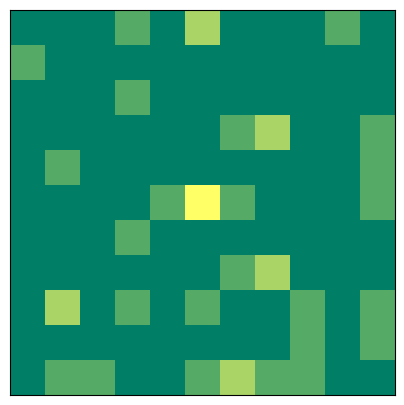

In [37]:
fig, axis = plt.subplots(figsize=(5, 5))
axis.set_xticks([])
axis.set_yticks([])
patch = plt.imshow(all_grids.iloc[0,0], cmap=plt.cm.summer)
def animate(i):
    patch.set_data(all_grids.iloc[i,0])

anim = animation.FuncAnimation(fig, animate,frames=len(all_grids))

In [38]:
anim